In [2]:
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

In [3]:
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x,y,z=state
    dxdt=sigma*(y-x)
    dydt=x*(rho-z)-y
    dzdt=x*y-beta*z
    return [dxdt, dydt, dzdt]

In [4]:
def generate_data(x0,y0,z0,num_data):
    state=[]
    init=np.array([x0,y0,z0])
    state.append(init)
    
    t_train=np.linspace(0,10,num_data)
    dt=t_train[1]-t_train[0]
    for _ in range(1, len(t_train)):
        state.append(state[-1]+np.array(lorenz(t_train[_], state[-1]))*dt)
    return state

In [5]:
x0,y0,z0=-8, 8, 27
num_data=1000
t_train=np.linspace(0,10,num_data)
data=generate_data(x0,y0,z0,num_data)

In [6]:
data=np.array(data)
data

array([[-8.        ,  8.        , 27.        ],
       [-6.3983984 ,  7.83983984, 25.63863864],
       [-4.97314933,  7.61012242, 24.45213091],
       ...,
       [ 8.65277405,  8.99356829, 26.75424073],
       [ 8.68688759,  9.01144321, 26.81905227],
       [ 8.71937564,  9.02392887, 26.88675919]])

In [7]:
t_train_tensor=torch.tensor(t_train.reshape(-1, 1), dtype=torch.float32)
states_tensor=torch.tensor(data, dtype=torch.float32)

In [8]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1=nn.Linear(1, 20)
        self.fc2=nn.Linear(20, 20)
        self.fc3=nn.Linear(20, 3)

    def forward(self, t):
        x=torch.sin(self.fc1(t))
        x=torch.sin(self.fc2(x))
        x=self.fc3(x)
        return x

In [9]:
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
for epoch in range(10000):
    optimizer.zero_grad()
    predicted_states=model(t_train_tensor)
    loss_model=torch.mean((predicted_states-states_tensor)**2)
    loss_phy=torch.abs(torch.mean(predicted_states[0]-states_tensor[0]))
    loss=loss_model+loss_phy
    loss.backward()
    optimizer.step()
    if epoch % 1000==0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 12.162013053894043
Epoch 1000, Loss: 10.9671630859375
Epoch 2000, Loss: 10.323256492614746
Epoch 3000, Loss: 9.72564697265625
Epoch 4000, Loss: 9.430729866027832
Epoch 5000, Loss: 9.152607917785645
Epoch 6000, Loss: 8.91405963897705
Epoch 7000, Loss: 8.591796875
Epoch 8000, Loss: 8.259295463562012
Epoch 9000, Loss: 7.930251598358154


In [19]:
t_test=np.linspace(0, 10, 1000)
t_test_tensor=torch.tensor(t_test.reshape(-1, 1), dtype=torch.float32)
predicted_states_test=model(t_test_tensor).detach().numpy()

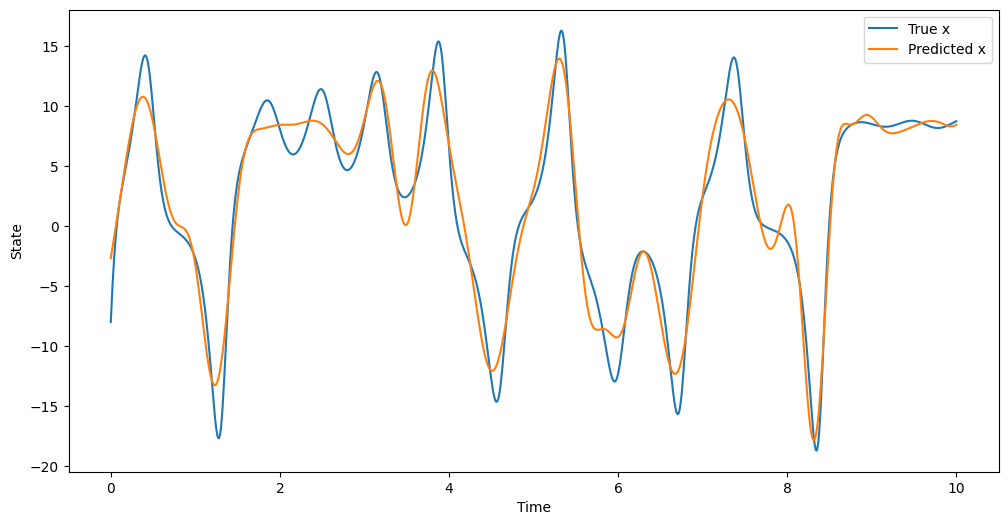

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(t_train, data[:, 0], label='True x')
plt.plot(t_test, predicted_states_test[:, 0], label='Predicted x')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

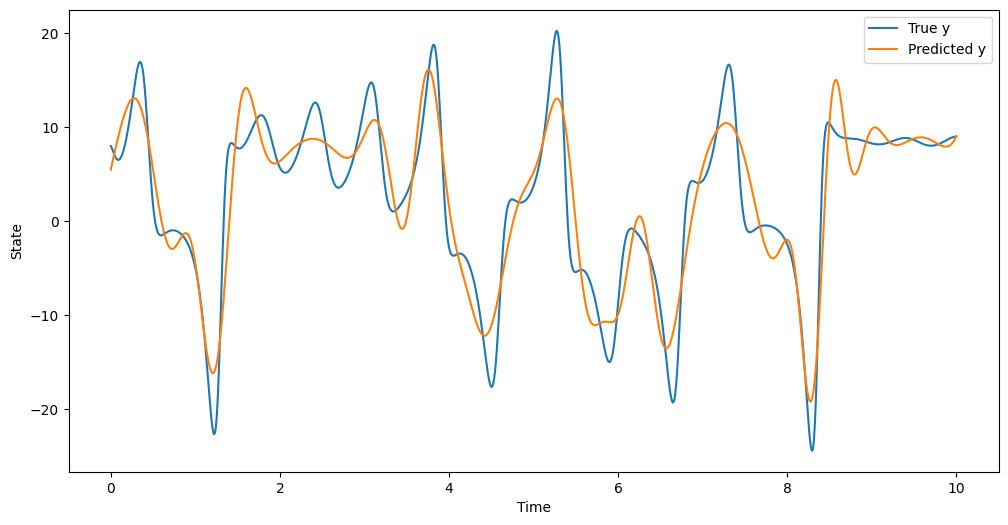

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(t_train, data[:, 1], label='True y')
plt.plot(t_test, predicted_states_test[:, 1], label='Predicted y')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

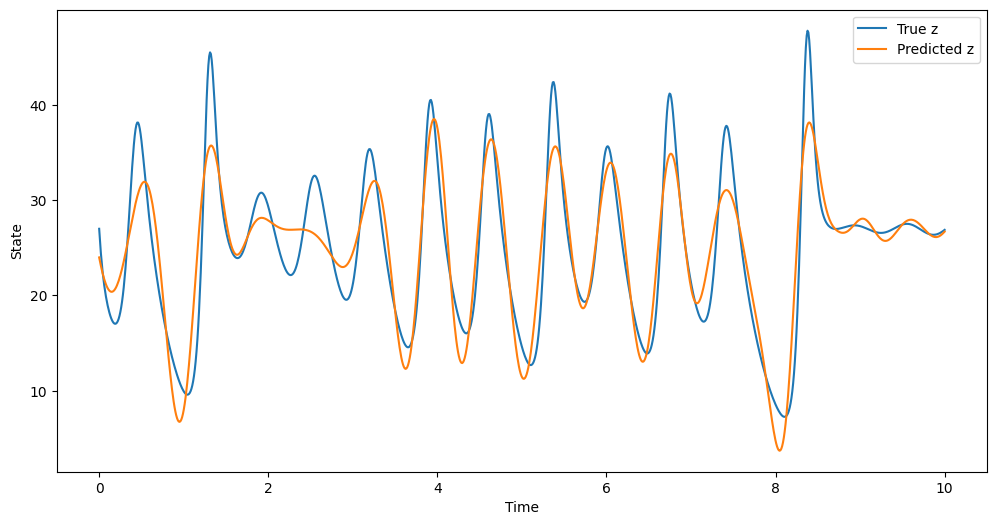

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(t_train, data[:, 2], label='True z')
plt.plot(t_test, predicted_states_test[:, 2], label='Predicted z')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

In [23]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2],
                           mode='lines', name='True Trajectory', line=dict(color='blue')))
fig.add_trace(go.Scatter3d(x=predicted_states_test[:, 0], y=predicted_states_test[:, 1], z=predicted_states_test[:, 2],
                           mode='lines', name='Predicted Trajectory', line=dict(color='red')))
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='Lorenz System Trajectories',
                  width=800, height=600)
fig.show()

In [24]:
checkpoint_path='lorenz.pt'
torch.save(model.state_dict(), checkpoint_path)